In [16]:
from picamera.array import PiRGBArray
from picamera import PiCamera
import datetime
import imutils
import json
import time
import cv2
from matplotlib import pyplot as plt

In [17]:
def show_image(img, cmap=None, vmin=None, vmax=None):
    plt.figure()
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.show()

[INFO] warming up...
[INFO] starting background model...
/home/pi/mnt/gdrive/images/20200513T150842.jpg


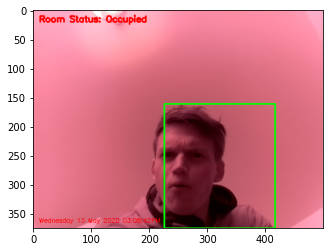

/home/pi/mnt/gdrive/images/20200513T150848.jpg


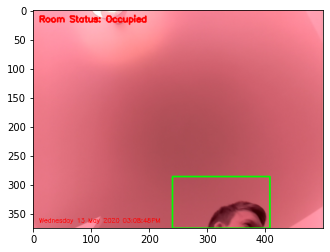

/home/pi/mnt/gdrive/images/20200513T150853.jpg


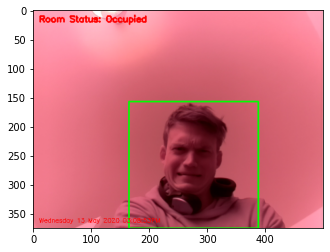

/home/pi/mnt/gdrive/images/20200513T150902.jpg


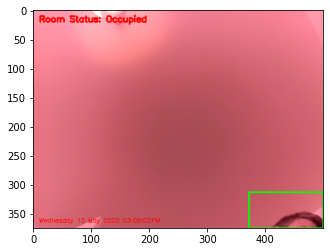

/home/pi/mnt/gdrive/images/20200513T150911.jpg


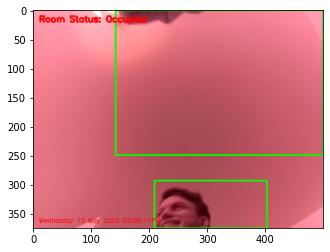

/home/pi/mnt/gdrive/images/20200513T150920.jpg


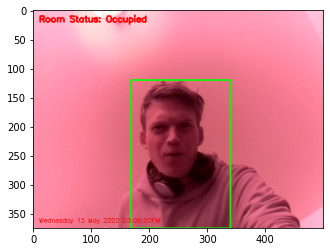

/home/pi/mnt/gdrive/images/20200513T150925.jpg


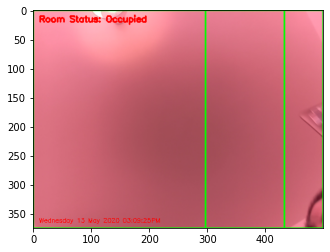

/home/pi/mnt/gdrive/images/20200513T150952.jpg


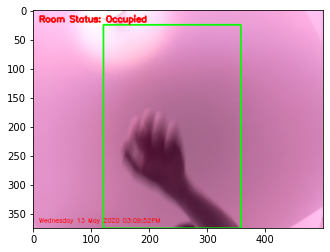

PiCameraValueError: Incorrect buffer length for resolution 640x480

In [22]:
conf = json.load(open("camera_config.json"))

try:
    # initialize the camera and grab a reference to the raw camera capture
    camera = PiCamera()
    camera.resolution = tuple(conf["resolution"])
    camera.framerate = conf["fps"]
    rawCapture = PiRGBArray(camera, size=tuple(conf["resolution"]))

    print("[INFO] warming up...")
    time.sleep(conf["camera_warmup_time"])

    avg = None
    lastUploaded = datetime.datetime.now()
    motionCounter = 0
    # capture frames from the camera
    for f in camera.capture_continuous(rawCapture, format="bgr", use_video_port=True):
        rawCapture.truncate(0)
        frame = f.array # numpy array
        timestamp = datetime.datetime.now()
        text = "Unoccupied"

        # resize the frame, convert it to grayscale, and blur it
        frame = imutils.resize(frame, width=500)
        colour = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #     show_image(colour)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #     show_image(gray, cmap='gray', vmin=0, vmax=255)

        gray = cv2.GaussianBlur(gray, (21, 21), 0)
    #     show_image(gray, cmap='gray', vmin=0, vmax=255)


        # if the average frame is None, initialize it
        if avg is None:
            print("[INFO] starting background model...")
            avg = gray.copy().astype("float")
            continue
        # accumulate the weighted average between the current frame and
        # previous frames, then compute the difference between the current
        # frame and running average
        cv2.accumulateWeighted(gray, avg, 0.5)
        frameDelta = cv2.absdiff(gray, cv2.convertScaleAbs(avg))

        # threshold the delta image, dilate the thresholded image to fill
        # in holes, then find contours on thresholded image
        thresh = cv2.threshold(frameDelta, conf["delta_thresh"], 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        # loop over the contours
        for c in cnts:
            # if the contour is too small, ignore it
            if cv2.contourArea(c) < conf["min_area"]:
                continue
            # compute the bounding box for the contour, draw it on the frame,
            # and update the text
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = "Occupied"
    #         show_image(frame)

        # draw the text and timestamp on the frame
        ts = timestamp.strftime("%A %d %B %Y %I:%M:%S%p")
        cv2.putText(
            frame,
            "Room Status: {}".format(text),
            (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            2,
        )
        cv2.putText(
            frame,
            ts,
            (10, frame.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.35,
            (0, 0, 255),
            1,
        )

        # check to see if the room is occupied
        if text == "Occupied":
            # check to see if enough time has passed between uploads
            if (timestamp - lastUploaded).seconds >= conf["min_upload_seconds"]:
                # increment the motion counter
                motionCounter += 1
                # check to see if the number of frames with consistent motion is
                # high enough
                if motionCounter >= conf["min_motion_frames"]:
                    # check to see if dropbox sohuld be used
                    if conf["save_image"]:
                        ts = timestamp.strftime("%Y%m%dT%H%M%S")
                        image_path = f"{conf['save_image_location']}/{ts}.jpg"
                        print(image_path)
    #                     cv2.imwrite(image_path, frame)
                        colour = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        show_image(colour)

                    # update the last uploaded timestamp and reset the motion
                    # counter
                    lastUploaded = timestamp
                    motionCounter = 0
        # otherwise, the room is not occupied
        else:
            motionCounter = 0
except KeyboardInterrupt:
    pass
camera.close()

In [23]:
camera.close()